# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [ ]:
from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # chose the GPU. If only one, then "0"

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [ ]:
calibration_ratio = 0.5  # set 0.5 to use 50% for calibration and 50% for testing

use_smaller_subset = True

if use_smaller_subset:
    data_cal, data_val = data.random_split(
        calibration_ratio, shuffled=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.random_split(calibration_ratio, shuffled=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
detr = DETRModel(model_name="detr_resnet50", pretrained=True)

print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = detr.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
)
preds_val = detr.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
)

File ./saved_predictions/detr_resnet50/mscoco/cal/predictions_object_detection.pkl does not exist
Predictions do not exist, building them...


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Saving predictions to ./saved_predictions/detr_resnet50/mscoco/cal/predictions_object_detection.pkl
File ./saved_predictions/detr_resnet50/mscoco/test/predictions_object_detection.pkl does not exist
Predictions do not exist, building them...


100%|██████████| 34/34 [00:15<00:00,  2.19it/s]


Saving predictions to ./saved_predictions/detr_resnet50/mscoco/test/predictions_object_detection.pkl


# 3. Test Conformal Prediction

In [6]:
from cods.od.cp import ODConformalizer

odc = ODConformalizer(
    localization_method="min-hausdorff-additive",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)

In [7]:
cal_output = odc.calibrate(preds_cal, alpha=0.2)

23it [00:00, 82.12it/s]

400it [00:05, 68.64it/s] 


Calibrated quantile: 0.9890493750572205
Quantiles
Confidence: 0.749849259853363
Localization: [tensor(20.7544, device='cuda:0'), tensor(20.7544, device='cuda:0'), tensor(20.7544, device='cuda:0'), tensor(20.7544, device='cuda:0')]
Classification: 0.9890493750572205


In [8]:
conf_boxes, conf_cls = odc.conformalize(preds_val)

In [9]:
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

100%|██████████| 400/400 [00:04<00:00, 99.83it/s] 

Confidence:
	 Coverage: 0.94
	 Mean Set Size: 15.55
Localization:
	 Coverage: 0.98
	 Mean Set Size: 276.25
Classification:
	 Coverage: 0.94
	 Mean Set Size: 71.51
Global:
	 Coverage: 0.84


In [10]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.2)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

  0%|          | 0/13 [00:00<?, ?it/s]

[1.22, 1.46] -> [1.3427734375]. Corrected Risk = 0.07: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Calibrated quantile: 0.9890493750572205
Quantiles
Confidence: 0.749849259853363
Localization: 1.46484375
Classification: 0.9890493750572205


100%|██████████| 400/400 [00:04<00:00, 81.92it/s] 

Confidence:
	 Coverage: 0.94
	 Mean Set Size: 15.55
Localization:
	 Coverage: 0.94
	 Mean Set Size: 79.38
Classification:
	 Coverage: 0.94
	 Mean Set Size: 71.51
Global:
	 Coverage: 0.47


In [11]:
from cods.od.tr import ODToleranceRegion

odc = ODToleranceRegion(
    localization_loss="pixelwise",
    confidence_loss="box_number",
    classification_loss="lac",
    multiple_testing_correction="bonferroni",
    inequality="bernstein",
)
odc.calibrate(preds_cal, alpha=0.2, delta=0.1, bounds=[0, 1000])
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

[0.83, 0.83] -> [0.8341064453125]. Corrected Risk = 0.07: 100%|██████████| 13/13 [00:00<00:00, 37.81it/s]
[1.95, 2.20] -> [2.0751953125]. Corrected Risk = 0.07: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
[0.99, 0.99] -> [0.9890365600585938]. Corrected Risk = 0.09: 100%|██████████| 26/26 [00:07<00:00,  3.59it/s]


Lambdas
Confidence: 0.8341064453125
Localization: 2.0751953125
Classification: 0.989044189453125


100%|██████████| 400/400 [00:05<00:00, 73.37it/s] 

Confidence:
	 Coverage: 0.95
	 Mean Set Size: 18.09
Localization:
	 Coverage: 0.95
	 Mean Set Size: 78.01
Classification:
	 Coverage: 0.88
	 Mean Set Size: 45.48
Global:
	 Coverage: 0.51


Using confidence threshold from preds


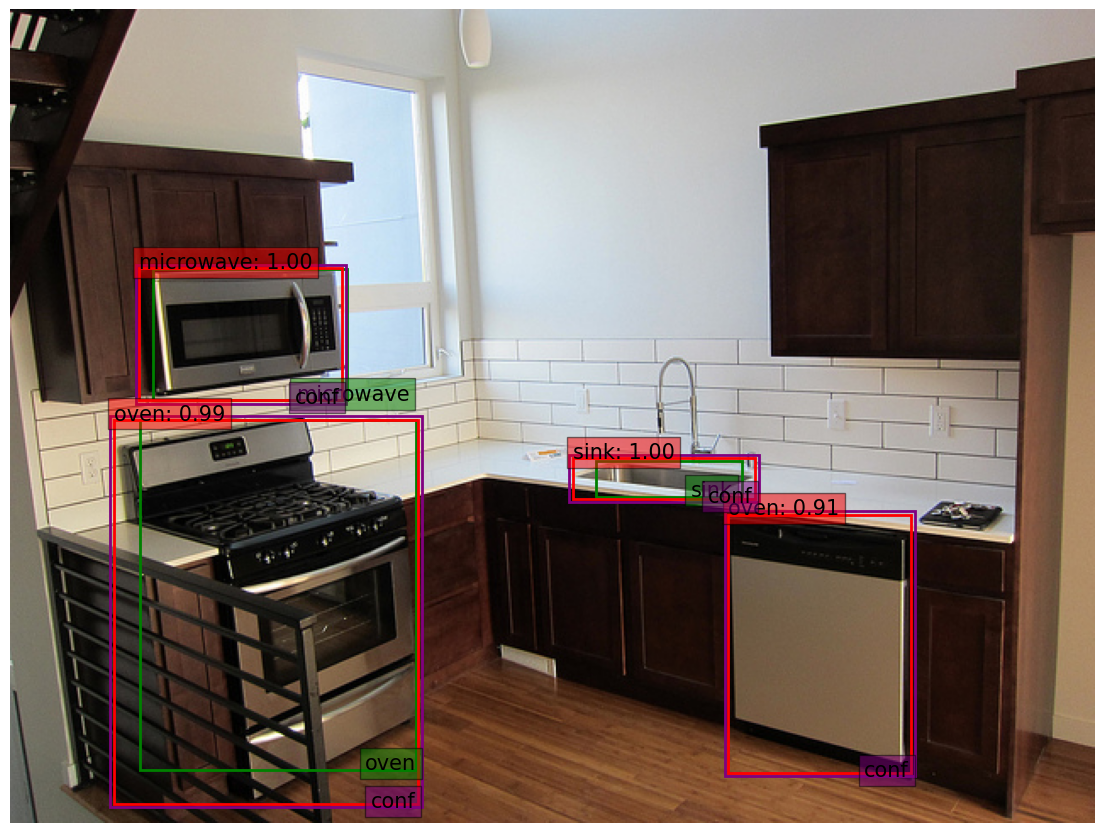

In [12]:
from cods.od.visualization import plot_preds

plot_preds(preds_val, 10, conf_boxes=conf_boxes, conf_cls=conf_cls)

In [19]:
from cods.od.metrics import unroll_metrics

unroll_metrics(od_preds=preds_val, conf_boxes=conf_boxes, conf_cls=conf_cls)

Defaulting to predictions' confidence threshold


Average Recall = 0.005, Average Precision = 1.0: 100%|██████████| 40/40 [01:53<00:00,  2.83s/it]                            


Average Precision: 0.7909144622488076


Average Recall = 0.005, Average Precision = 1.0: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]                            

(Conformalist) Average Precision: 0.7702853159101887
